In [1]:
import requests
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Get and read in data

In [2]:
%run zillow_data_scrape.py

Enter the city name:  moorhead
Enter the state in abbreviation format (eg: Minnesota = MN) :  mn


Scraping data...
Done.
Moorhead_Homes_ForSale.csv is available for viewing.
Moorhead_Apartments_ForRental.csv is available for viewing.


In [3]:
df = pd.read_csv("./data/Moorhead_Homes_ForSale.csv")
df2 = pd.read_csv("./data/Moorhead_Apartments_ForRental.csv")

null_price = df[df["unformattedPrice"].isnull()]
null_price2 = df2[df2["unformattedPrice"].isnull()]
df.drop(null_price.index, inplace=True)
df2.drop(null_price2.index, inplace=True)

#set zestimate equal to price if 0, set best_deal equal to division
df.loc[(df['zestimate'].isnull()) | (df['zestimate'] == 0), 'zestimate'] = df['unformattedPrice']
df['best_deal'] = df['zestimate'] - df['unformattedPrice']
df.sort_values("best_deal")

df2.loc[(df2['zestimate'].isnull()) | (df2['zestimate'] == 0), 'zestimate'] = df2['unformattedPrice']
df2['best_deal'] = df2['zestimate'] - df2['unformattedPrice']
df2.sort_values("unformattedPrice")
df.head()

,Unnamed: 0,zpid,imgSrc,statusType,price,unformattedPrice,zestimate,best_deal,address,addressZipcode,beds,baths,area,variableData,brokerName,builderName
0,96,89307665,https://photos.zillowstatic.com/fp/755eef14c71...,FOR_SALE,"$32,900",32900,480600,447700,"2306 38th St S, Moorhead, MN 56560",56560,NaN,NaN,NaN,"{'type': 'DAYS_ON', 'text': '3 days on Zillow'}",Justin Berg Realty,NaN
1,109,89314124,https://photos.zillowstatic.com/fp/38ab63442a6...,FOR_SALE,"$39,900",39900,403800,363900,"2314 36th St S, Moorhead, MN 56560",56560,NaN,NaN,NaN,"{'type': 'DAYS_ON', 'text': '3 days on Zillow'}",Justin Berg Realty,NaN
2,361,89224643,https://photos.zillowstatic.com/fp/567fc16b315...,FOR_SALE,"$195,000",195000,196349,1349,"1118 4th St S, Moorhead, MN 56560",56560,4.0,2.0,1976.0,"{'type': 'DAYS_ON', 'text': '36 days on Zillow'}",RE/MAX Legacy Realty,NaN
3,359,89265279,https://photos.zillowstatic.com/fp/c70c8d5b010...,FOR_SALE,"$195,000",195000,195102,102,"1214 5th St S, Moorhead, MN 56560",56560,4.0,2.0,1884.0,"{'type': 'DAYS_ON', 'text': '36 days on Zillow'}",RE/MAX Legacy Realty,NaN
4,60,222143113,https://photos.zillowstatic.com/fp/8bb283d181e...,FOR_SALE,"$297,560",297560,297562,2,"1138 46th Ave S, Moorhead, MN 56560",56560,3.0,2.0,1703.0,"{'type': 'DAYS_ON', 'text': '35 days on Zillow'}",Realty Xperts,NaN


## Homes

#### averages of price and best deal

In [4]:
home_averages = df.copy()

# Step 1: Select columns of number home_averages type
num_cols = home_averages.select_dtypes(include=['int', 'float']).drop(['zpid', 'addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()
median_row = num_cols.median()
mode_row = num_cols.mode()

mean_row = pd.DataFrame(mean_row)
mean_row = mean_row.transpose()

median_row = pd.DataFrame(median_row)
median_row = median_row.transpose()

mode_row = pd.DataFrame(mode_row)
mode_row = mode_row.head(1)

# Step 3: Append new row to home_averagesframe
home_averages = home_averages.append(mean_row, ignore_index=True)
home_averages = home_averages.append(median_row, ignore_index=True)
home_averages = home_averages.append(mode_row, ignore_index=True)

home_averages = home_averages.round(decimals = 2)

home_averages = home_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

home_averages = home_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
home_averages['name'] = names

# create a new column with the same values as the "name" column
new_col = home_averages['name']

# remove the original "name" column
home_averages = home_averages.drop('name', axis=1)

# add the new column in the first position
home_averages.insert(0, 'name', new_col)

print('Average House For Sale in Moorhead: ')
home_averages

Average House For Sale in Moorhead: 


,name,unformattedPrice,zestimate,best_deal,beds,baths,area
181,Mean,193688.43,197413.62,3725.19,3.76,2.42,2332.79
182,Median,65000.00,69900.00,0.00,4.00,2.00,2095.00
183,Mode,25900.00,25900.00,0.00,3.00,2.00,1792.00


In [5]:
## Histogram of prices

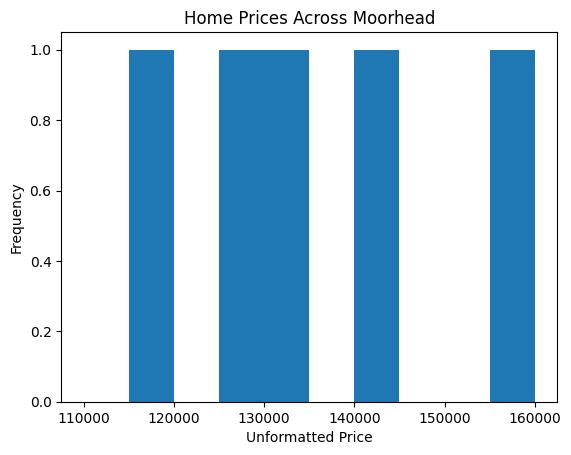

In [6]:
plt.hist(df['unformattedPrice'], bins=10, range=(110000, 160000))
plt.xlabel('Unformatted Price')
plt.ylabel('Frequency')
plt.title('Home Prices Across Moorhead')
plt.show()

#### Pie chart of builders

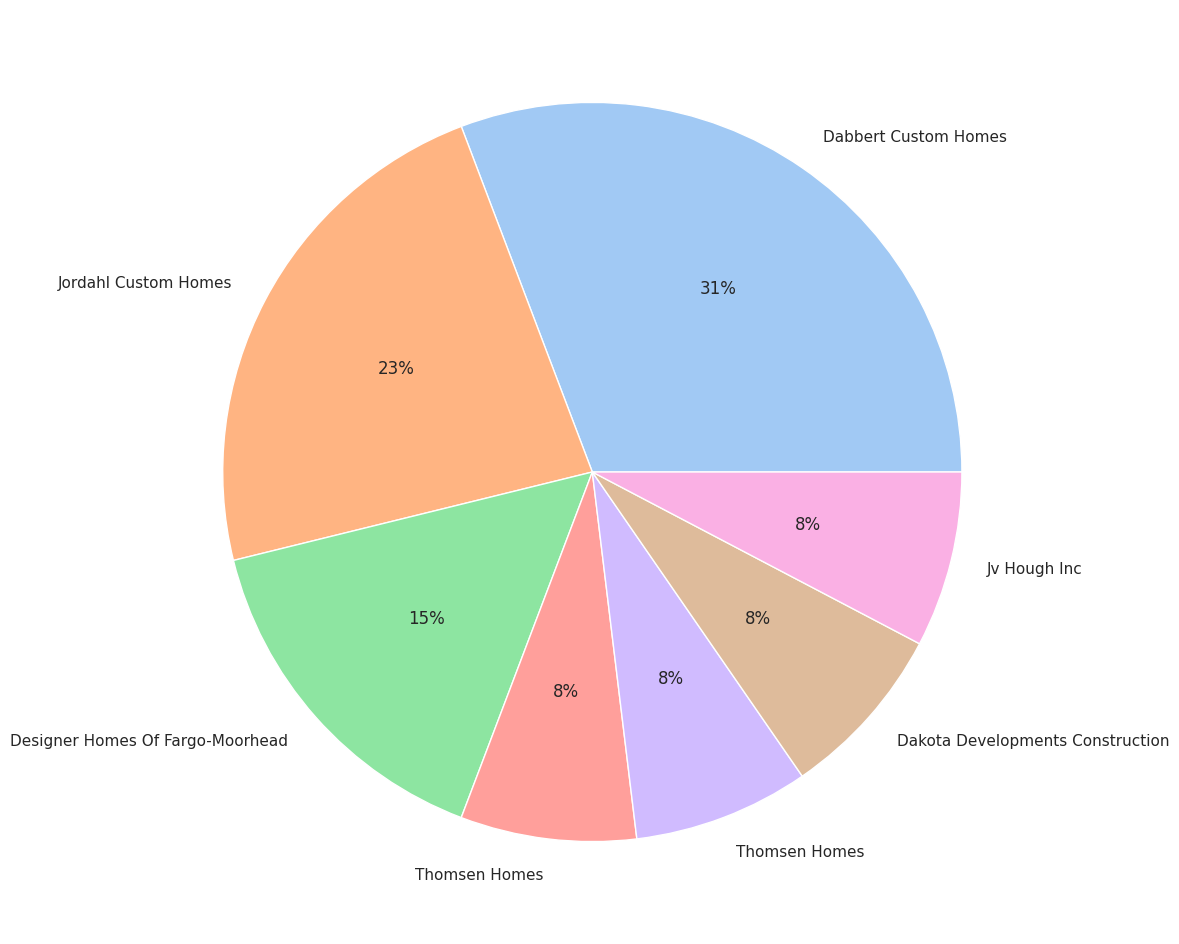

In [7]:
builders = df.copy()

#builders["builderName"].fillna("Not Listed", inplace=True)
builders['builderName'] = builders['builderName'].str.replace(', llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace('llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace(', inc', '', case=False)

# create pandas series of counts of unique values in "builderName" column
builder_counts = builders['builderName'].value_counts()

# extract values and index of pandas series
data = builder_counts.values
labels = builder_counts.index

# define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(data)]

sns.set(rc={"figure.figsize":(40, 12)})
# create pie chart
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

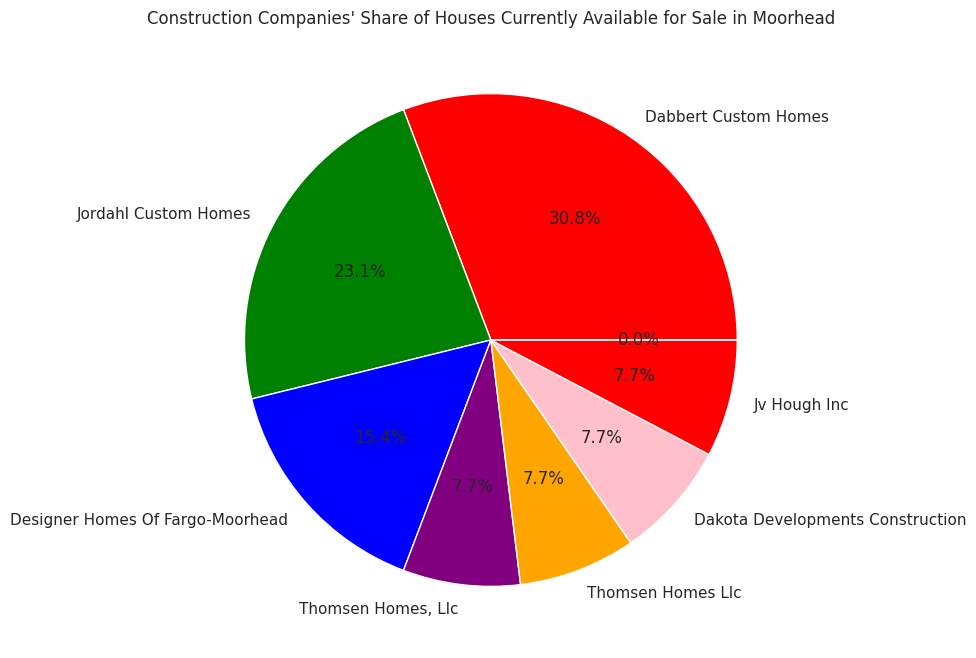

In [8]:
builder_count = df["builderName"].value_counts()

total = builder_count.sum()
threshold = total * 0.02

other_count = builder_count[builder_count < threshold].sum()
builder_count = builder_count[builder_count >= threshold]
builder_count["other"] = other_count

builder_count.plot.pie(figsize=(8, 8), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink'])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Moorhead")
plt.ylabel("")
plt.show()

In [9]:
## Pie chart of brokers

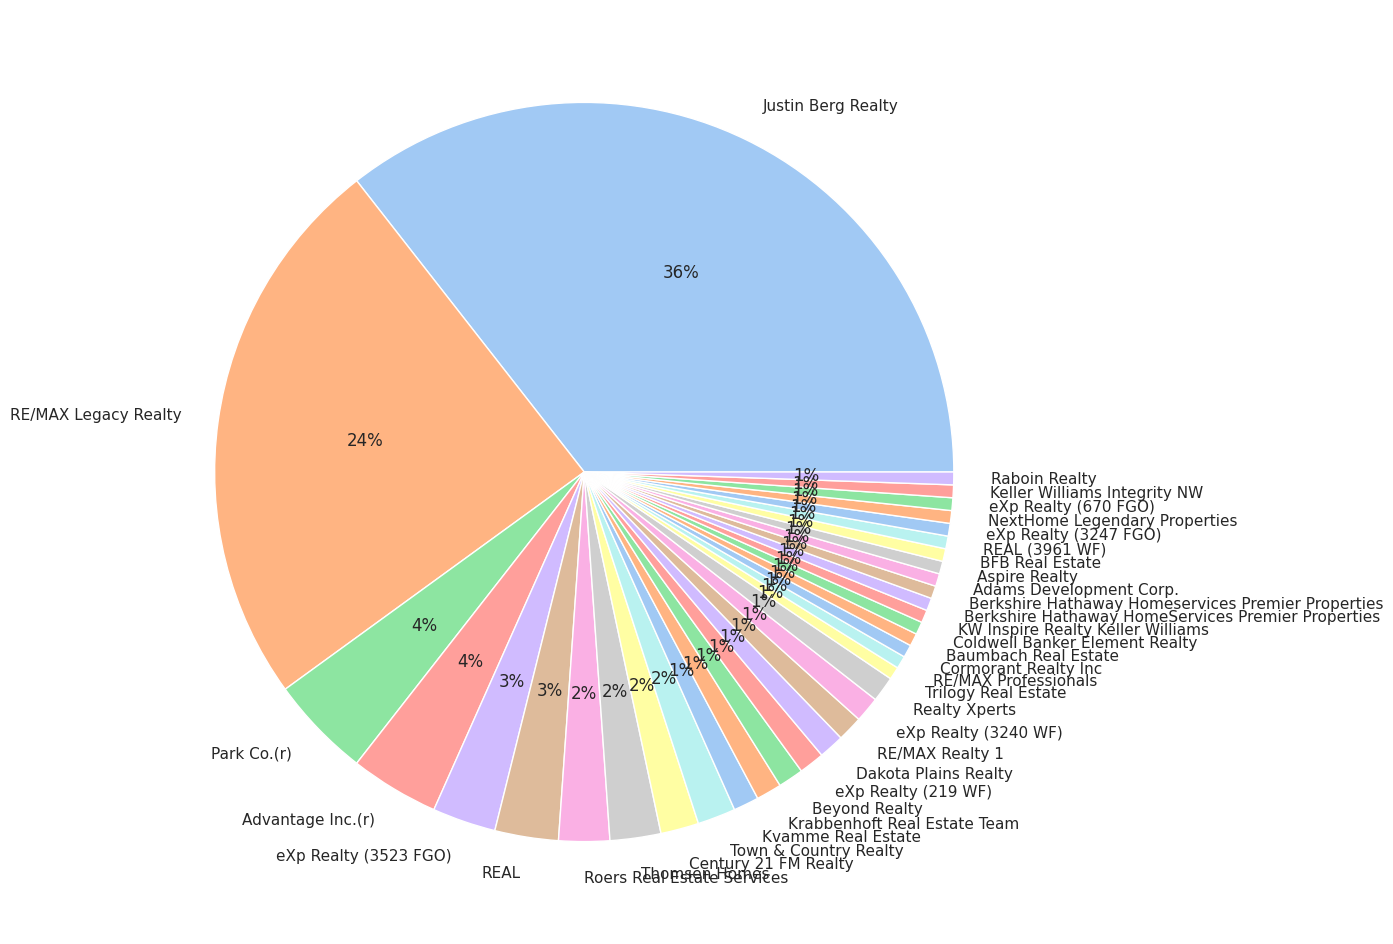

In [10]:
brokers = df.copy()
#brokers["brokerName"].fillna("Not Listed", inplace=True)
brokers['brokerName'] = brokers['brokerName'].str.replace(', llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace('llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace(', inc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace(', REALTORS', '', case=False)

# create pandas series of counts of unique values in "brokerName" column
broker_counts = brokers['brokerName'].value_counts()

# extract values and index of pandas series
data = broker_counts.values
labels = broker_counts.index

# define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(data)]

sns.set(rc={"figure.figsize":(40, 12)})\

# create pie chart
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

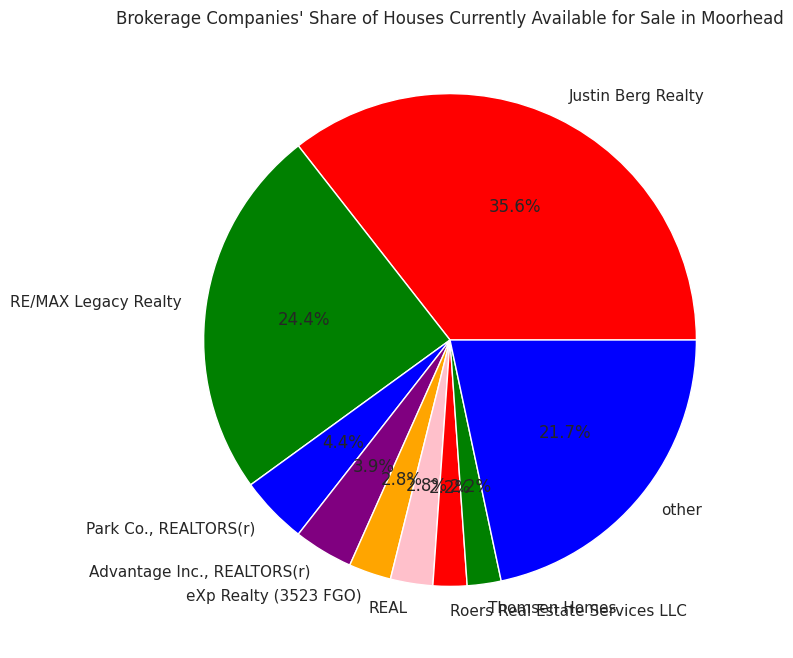

In [11]:
broker_count = df["brokerName"].value_counts()

total = broker_count.sum()
threshold = total * 0.02

other_count = broker_count[broker_count < threshold].sum()
broker_count = broker_count[broker_count >= threshold]
broker_count["other"] = other_count

broker_count.plot.pie(figsize=(8, 8), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink'])
plt.title("Brokerage Companies' Share of Houses Currently Available for Sale in Moorhead")
plt.ylabel("")
plt.show()

In [12]:
## Beds and Baths

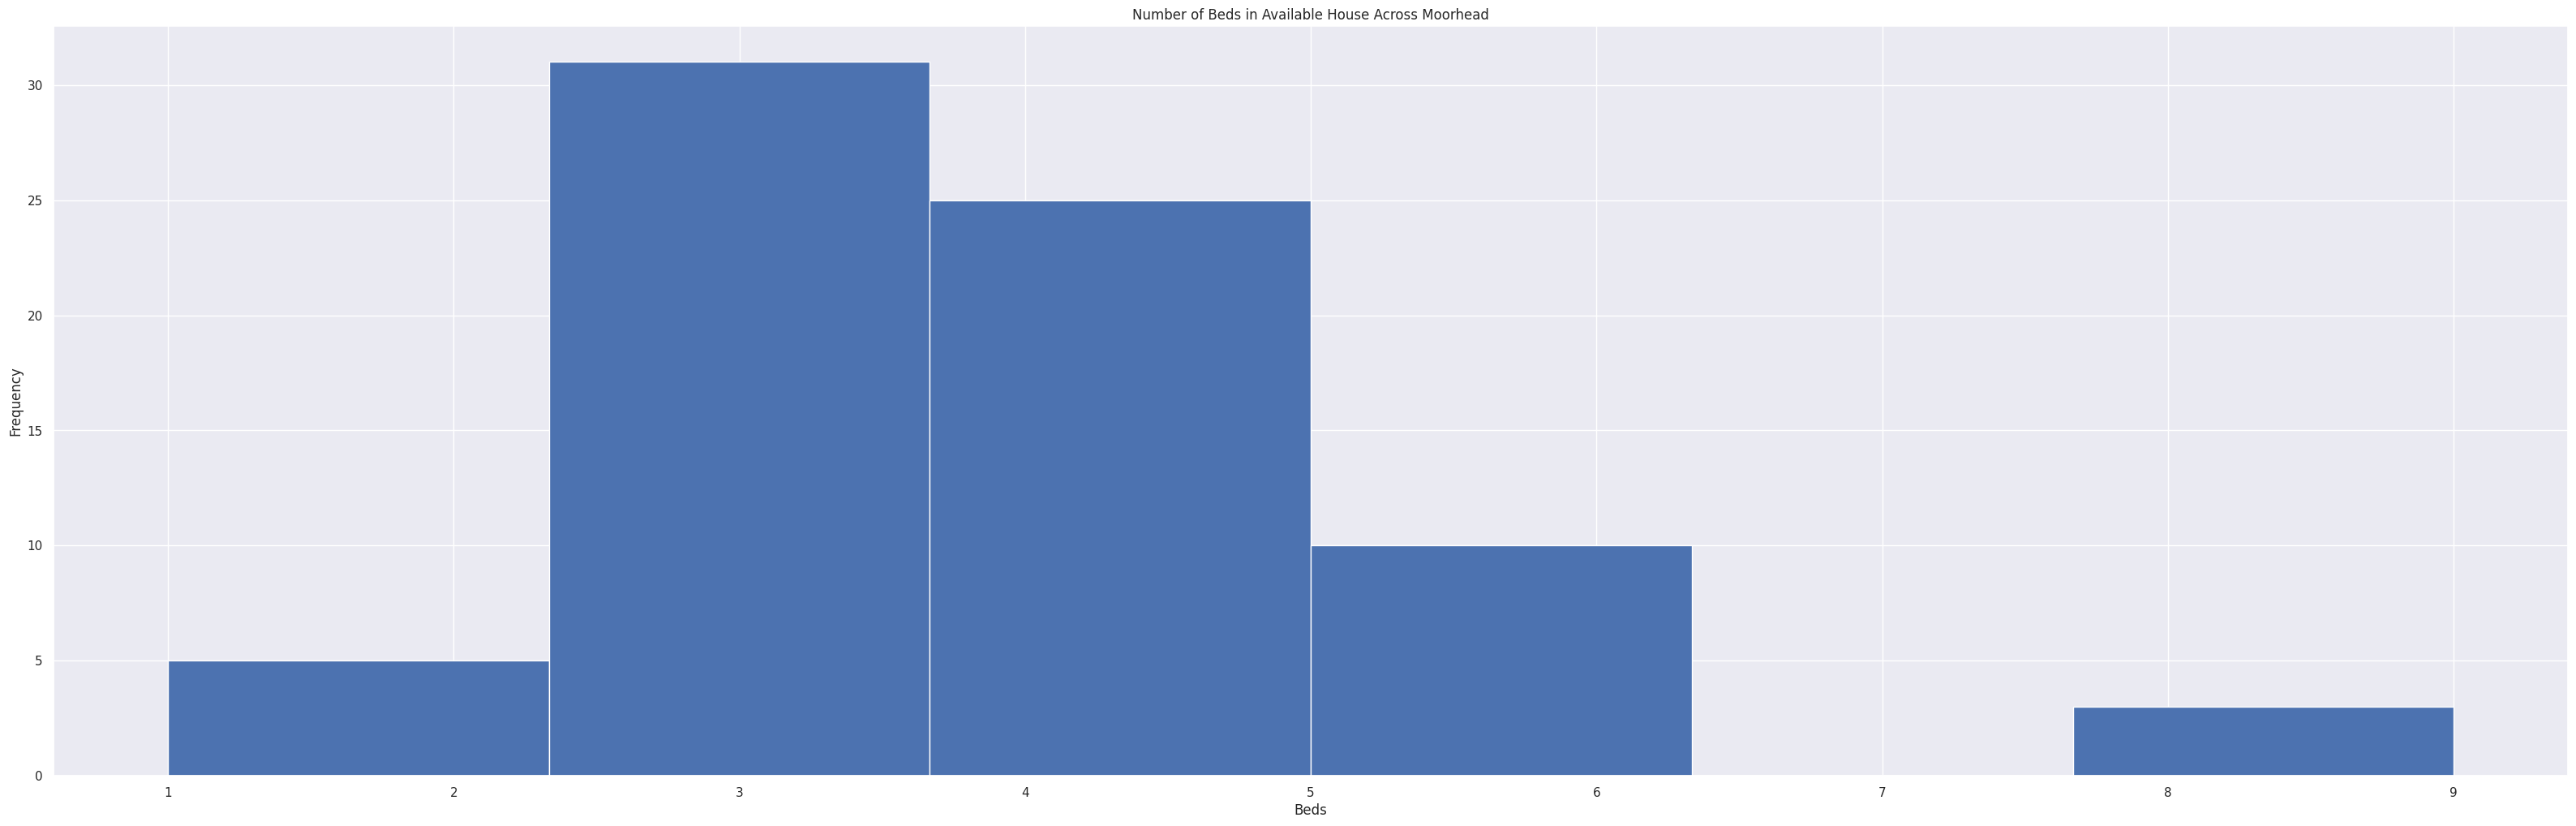

In [13]:
plt.hist(df['beds'], bins=6)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Available House Across Moorhead')
plt.show()

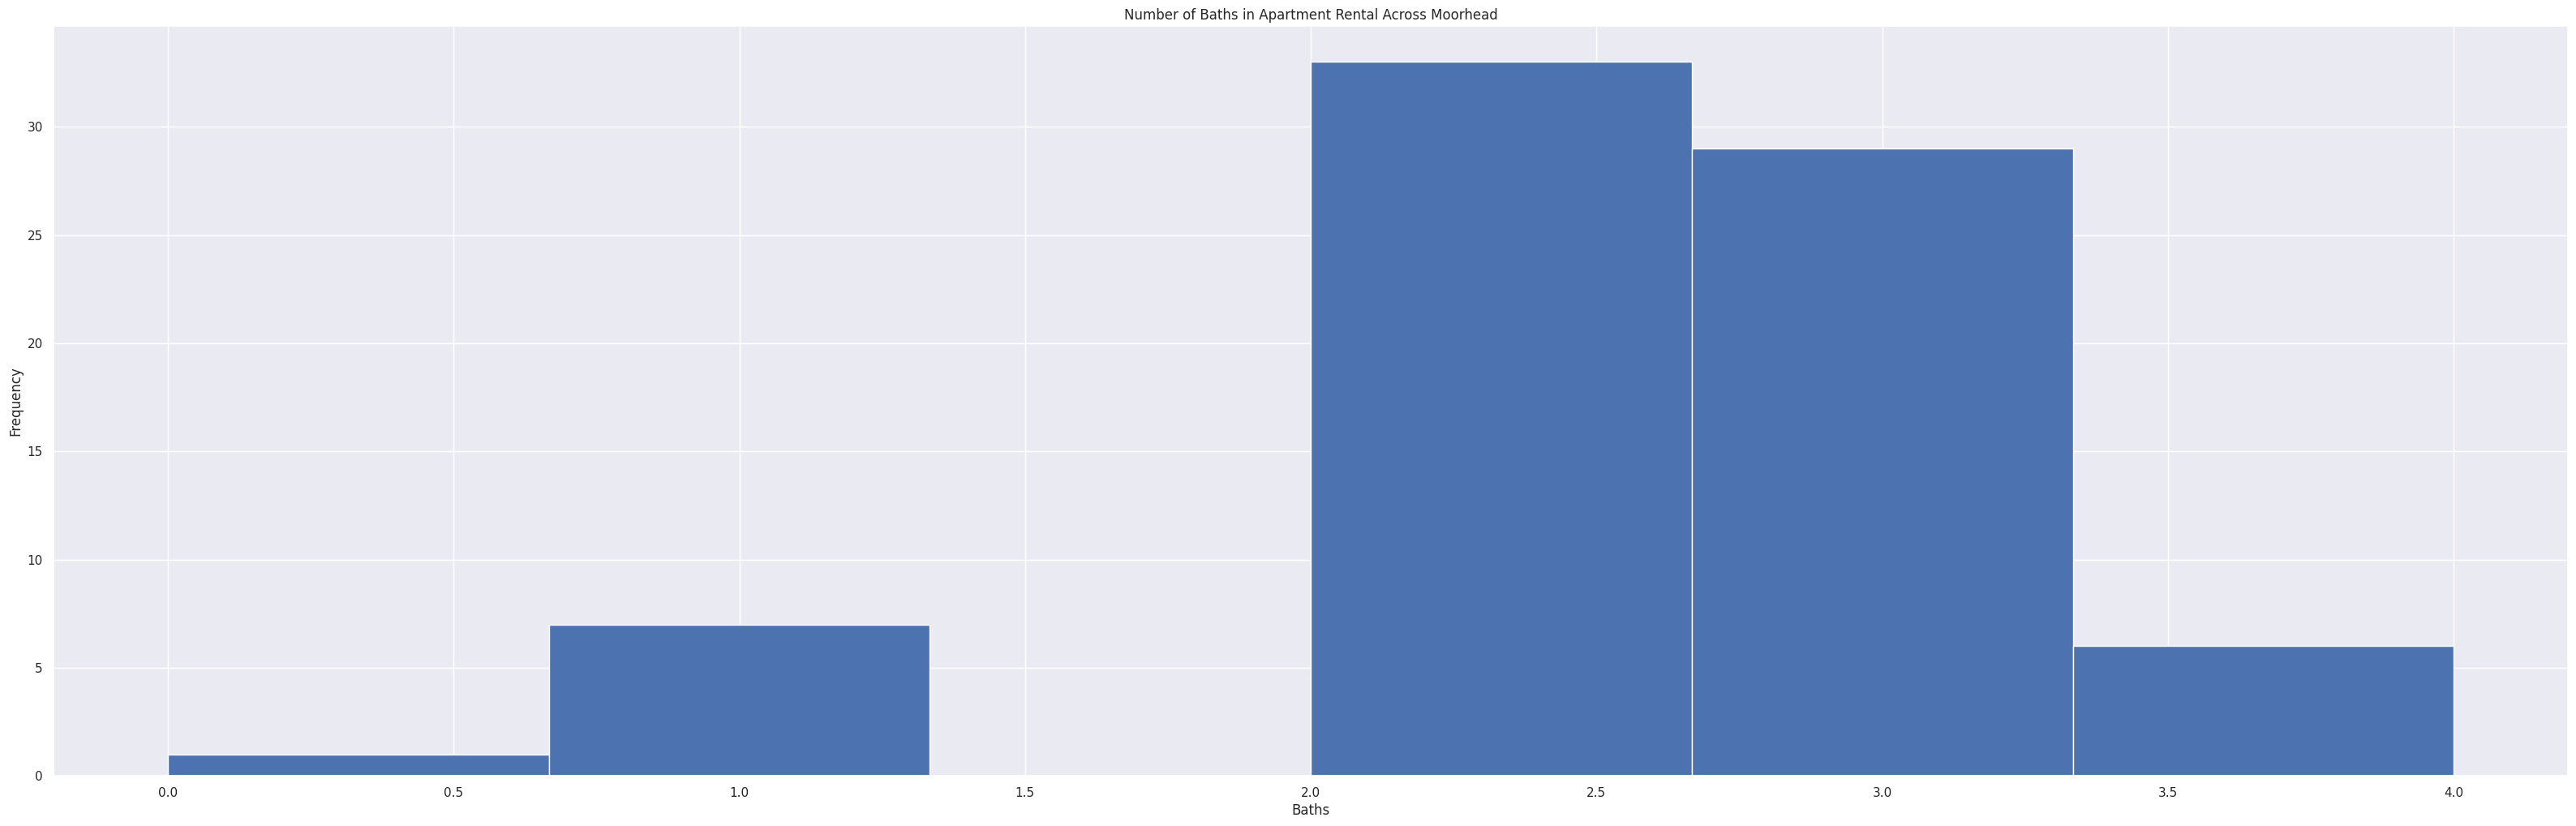

In [14]:
plt.hist(df['baths'], bins=6)
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across Moorhead')
plt.show()

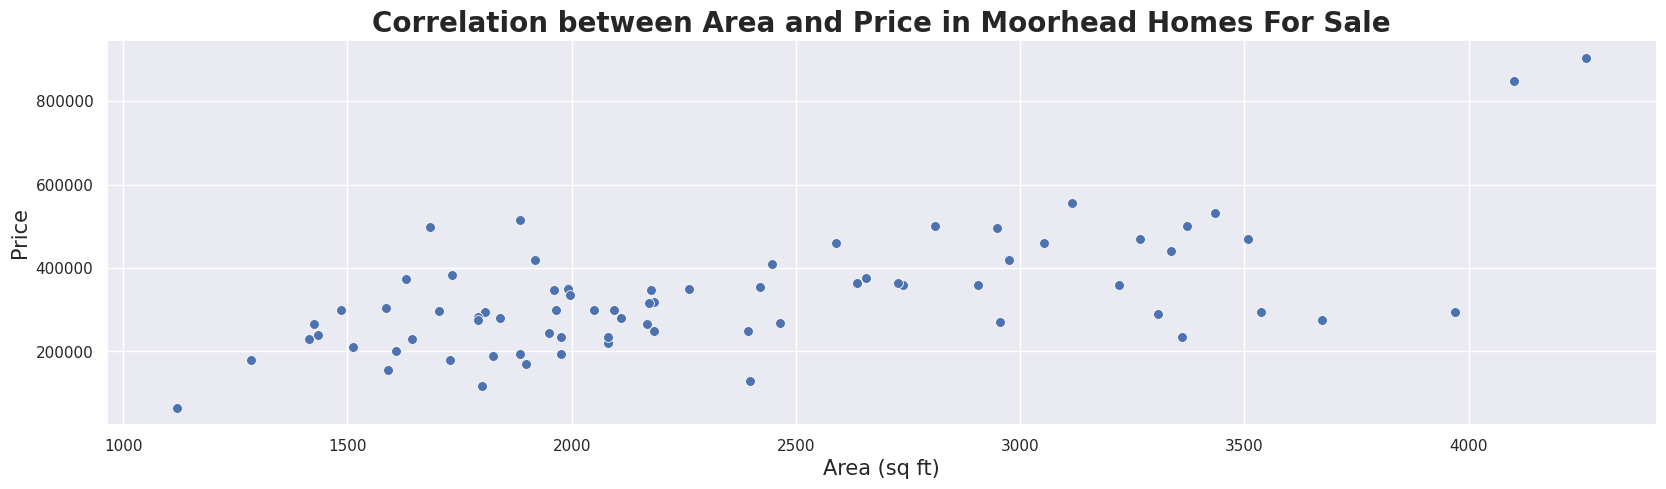

In [15]:
#Scatter plot comparing Area with Price
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in Moorhead Homes For Sale", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()

## Apartments

In [16]:
## averages of price and best deal

In [17]:
apt_averages = df2.copy()

# Step 1: Select columns of number apt_averages type
num_cols = apt_averages.select_dtypes(include=['int', 'float']).drop(['addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()
median_row = num_cols.median()
mode_row = num_cols.mode()

mean_row = pd.DataFrame(mean_row)
mean_row = mean_row.transpose()

median_row = pd.DataFrame(median_row)
median_row = median_row.transpose()

mode_row = pd.DataFrame(mode_row)
mode_row = mode_row.head(1)

# Step 3: Append new row to apt_averagesframe
apt_averages = apt_averages.append(mean_row, ignore_index=True)
apt_averages = apt_averages.append(median_row, ignore_index=True)
apt_averages = apt_averages.append(mode_row, ignore_index=True)

apt_averages = apt_averages.round(decimals = 2)

apt_averages = apt_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

apt_averages = apt_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
apt_averages['name'] = names

# create a new column with the same values as the "name" column
new_col = apt_averages['name']

# remove the original "name" column
apt_averages = apt_averages.drop('name', axis=1)

# add the new column in the first position
apt_averages.insert(0, 'name', new_col)

print('Average Apartment For Rental in Moorhead: ')
apt_averages

Average Apartment For Rental in Moorhead: 


,name,unformattedPrice,zestimate,best_deal,beds,baths,area
25,Mean,855.25,11540.25,10685.0,2.1,1.12,857.75
26,Median,812.50,812.50,0.0,2.0,1.00,821.00
27,Mode,550.00,550.00,0.0,1.0,1.00,714.00


In [18]:
## Histogram of price

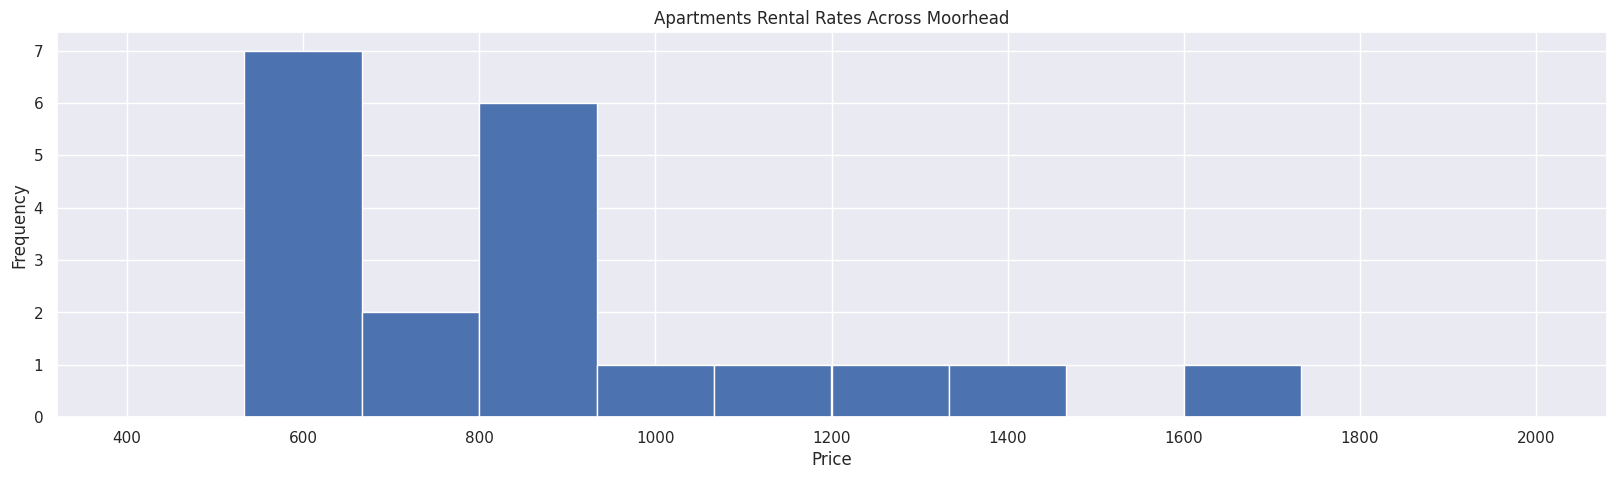

In [19]:
plt.hist(df2['unformattedPrice'], bins=12, range=(400, 2000))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Apartments Rental Rates Across Moorhead')
plt.show()

In [20]:
## beds, baths, and area

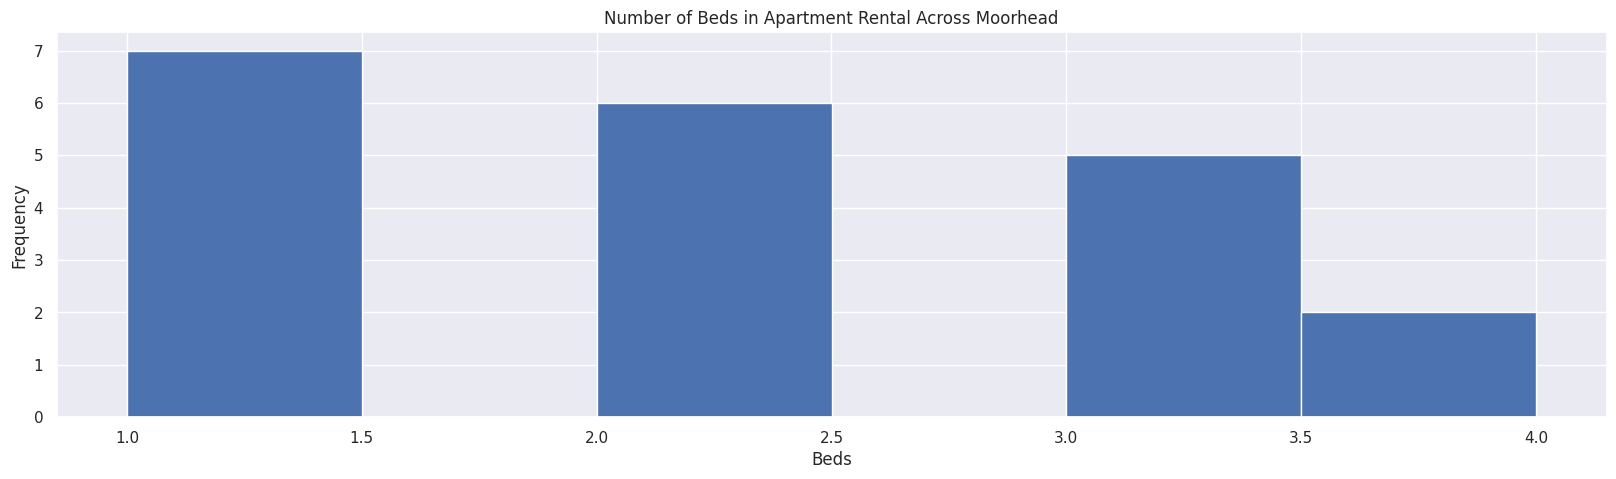

In [21]:
plt.hist(df2['beds'], bins=6)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Apartment Rental Across Moorhead')
plt.show()

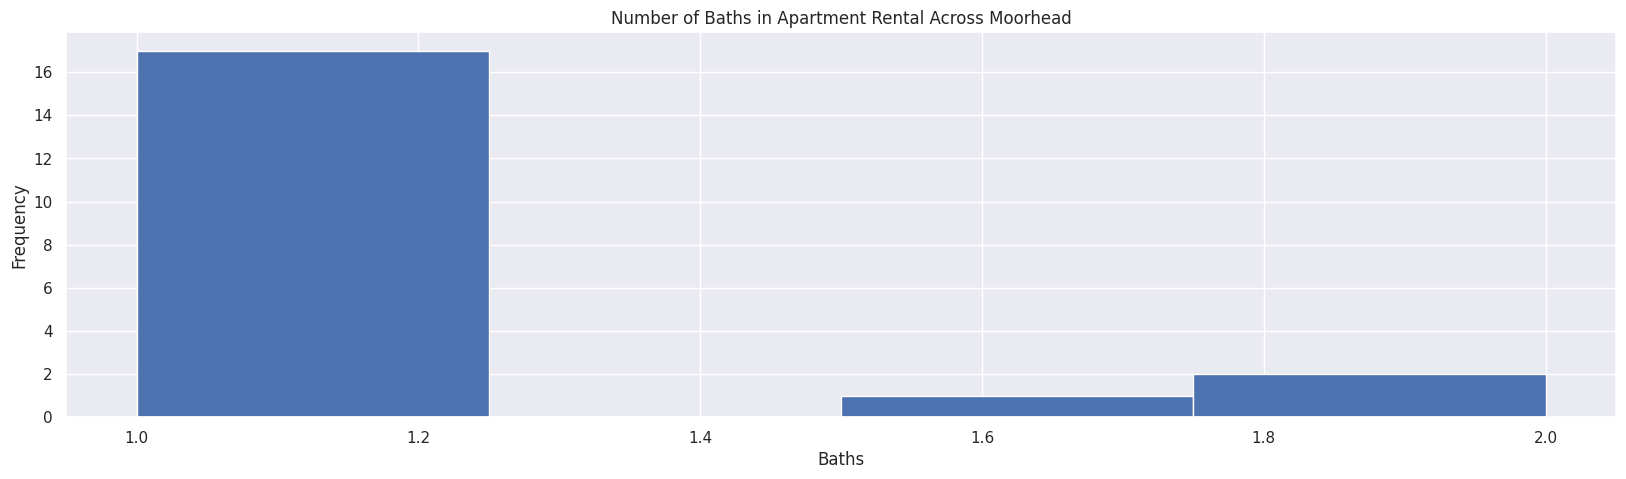

In [22]:
plt.hist(df2['baths'], bins=4)
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across Moorhead')
plt.show()

In [23]:
## Pie chart of builders

In [24]:
## Pie chart of brokers

In [25]:
## Pie chart of open house

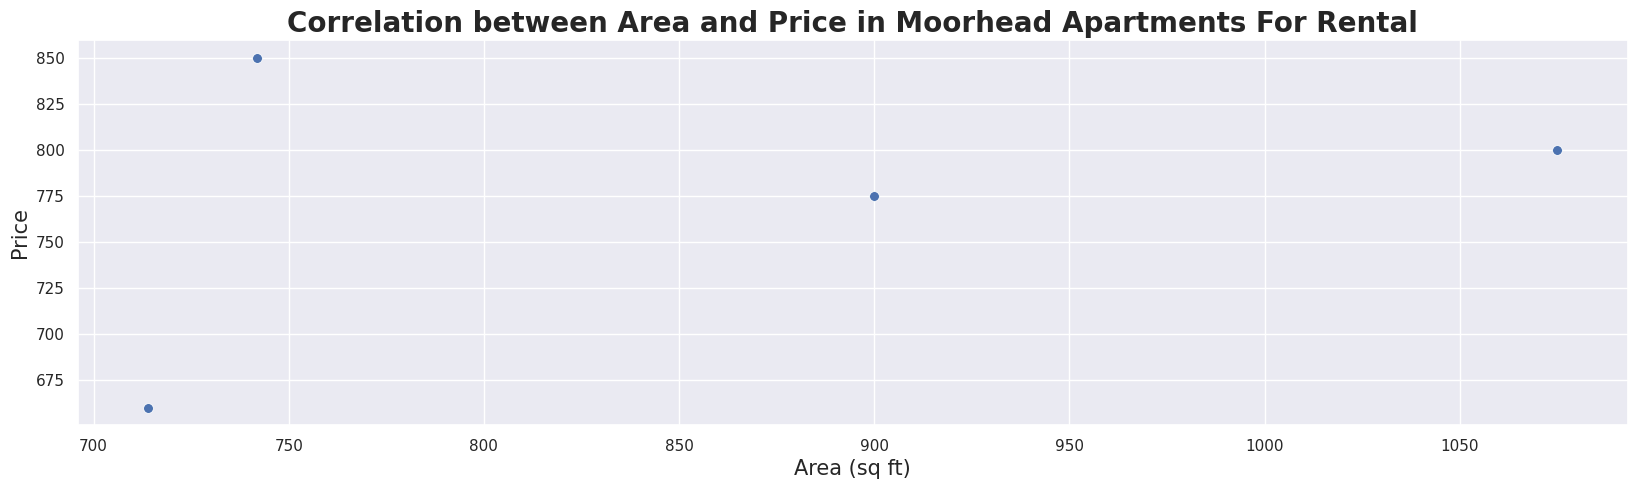

In [26]:
#Scatter plot comparing Area with Price
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df2, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in Moorhead Apartments For Rental", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()